In [1]:
import numpy as np
import scipy as sp

import scipy
from scipy.stats import multivariate_normal
from scipy       import optimize

import skimage

import matplotlib.pyplot as plt

import pylab

from glob import glob
import sys

import itk
from itkwidgets import view

from tqdm import tqdm

import math

In [2]:
num_mask = 3
im_mask = []
im_mask.append(itk.GetArrayFromImage(itk.imread("EstimatedMask_Depth5_Edited.png", itk.F)))
im_mask.append(itk.GetArrayFromImage(itk.imread("EstimatedMask_Depth12_Edited.png", itk.F)))
im_mask.append(itk.GetArrayFromImage(itk.imread("EstimatedMask_Depth16_Edited.png", itk.F)))
im_mask_depth = [5,12,16]

In [3]:
def get_top_and_bottom_curve_points_C52(im, centerX):
    """ Find points along the top (yt) and bottom (yb) curves of the ultrasound image """
    min_x = int(centerX-centerX*0.1)
    max_x = int(centerX+centerX*0.1)
    step_x = 10
    size_x = int((max_x - min_x)/step_x)
    xt = np.zeros(size_x, dtype=int)
    yt = np.zeros(size_x, dtype=int)
    for t in range(size_x):
        xt[t] = int(min_x + t * step_x)
        mid = np.mean(im[:,xt[t]-2:xt[t]+2],axis=1)
        nz = np.flatnonzero(mid)
        yt[t] = nz[0]
    min_x = int(centerX-centerX*0.25)
    max_x = int(centerX+centerX*0.25)
    step_x = 10
    size_x = int((max_x - min_x)/step_x)
    xb = np.zeros(size_x, dtype=int)
    yb = np.zeros(size_x, dtype=int)
    for t in range(size_x):
        xb[t] = int(min_x + t * step_x)
        mid = np.mean(im[:,xb[t]-2:xb[t]+2],axis=1)
        nz = np.flatnonzero(mid)
        yb[t] = nz[nz.size-1]
    return xt,yt,xb,yb

def calculate_radius(xc, yc, x, y):
    """ calculate the distance of each data points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def calculate_radius_C52(yc, x, y, centerX):
    """ calculate the distance of each data points from the center (xc, yc) """
    return np.sqrt((x-centerX)**2 + (y-yc)**2)

def fit_circle(c, x, y):
    """ calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc) """
    Ri = calculate_radius(*c, x, y)
    return Ri - Ri.mean()

def fit_circle_C52(c, x, y, centerX):
    """ calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc) """
    Ri = calculate_radius_C52(*c, x, y, centerX)
    return Ri - Ri.mean()

In [4]:
def get_circles_from_points(x, y, center, use_C52=True):
    # solve for top circle
    centerX0 = center[0]
    centerY = center[1]
    if use_C52:
        center_estimate, ier = optimize.leastsq(fit_circle_C52,centerY,args=(x,y,centerX0),col_deriv=True)
        Ri                   = calculate_radius_C52(*center_estimate,x,y,centerX)
        x_estimate = centerX0
        y_estimate = center_estimate[0]
        r_estimate = Ri.mean()
    else:
        center_estimate, ier = optimize.leastsq(fit_circle,center,args=(x,y),col_deriv=True)
        Ri                = calculate_radius(*center_top_estimate,x,y)
        x_estimate = center_estimate[0]
        y_estimate = center_estimate[1]
        r_estimate = Ri.mean()
    return x_estimate, y_estimate, r_estimate

In [5]:
# Compute a least squares estimate the top and bottom circles from lists of points along the top and bottom curves
#   for every ultrasound video (represented by a mean 2D image)

centerX = 0
for i in range(3):
    im = (im_mask[i]>0).astype(np.uint8)
    c = scipy.ndimage.measurements.center_of_mass(im)[1]
    centerX += c
    print(c)
centerX = int(np.round(centerX/3,0))

centert = (centerX, -55)
centerb = (centerX, -721)

x_top_estimate = np.zeros(num_mask)
y_top_estimate = np.zeros(num_mask)
r_top_estimate = np.zeros(num_mask)
x_bottom_estimate = np.zeros(num_mask)
y_bottom_estimate = np.zeros(num_mask)
r_bottom_estimate = np.zeros(num_mask)

for i in range(3):
    xt,yt,xb,yb = get_top_and_bottom_curve_points_C52(im_mask[i], centerX)
    
    x_top_estimate[i], y_top_estimate[i], r_top_estimate[i] = get_circles_from_points(xt, yt, centert, use_C52=True)
    x_bottom_estimate[i], y_bottom_estimate[i], r_bottom_estimate[i] = get_circles_from_points(xb, yb, centerb, use_C52=True)

    
    print(im_mask_depth[i])
    print("   Top: ", x_top_estimate[i], y_top_estimate[i], r_top_estimate[i])
    print("   Bottom: ", x_bottom_estimate[i], y_bottom_estimate[i], r_bottom_estimate[i])
    print()
    

952.6726509025195
955.6742272738779
953.6145025854096
5
   Top:  954.0 11.143492642914767 421.5909040997465
   Bottom:  954.0 -85.72432851471096 908.1117281864598

12
   Top:  954.0 21.79736469989889 233.1021061407371
   Bottom:  954.0 -334.38808522118984 1262.892672512338

16
   Top:  954.0 -120.74286198368526 297.8172838772864
   Bottom:  954.0 162.20133192135734 889.5753071341097



In [6]:
def get_linear_map_C52(mask, xt, yt, rt, xb, yb, rb, ray_density = 0.5, blur = 0.5):
    try:
        assert(blur > 0)
    except:
        sys.exit("blur needs to be greater than zero")

    center_x = (xt + xb)/2 
    center_y = (3*yt + yb)/4
    center = np.array([center_x, center_y])

    inner_radius = (yt+rt)-center_y
    outer_radius = (yb+rb)-center_y
    
    print(center_x, center_y, inner_radius, outer_radius)

    radii = np.array([inner_radius, outer_radius])
    angle = (67.5/180)*math.pi
    
    left_angle = -angle/2
    right_angle = angle/2

    # determine the x and y sizes of the resampled image
    # from ray density. y size will be sector depth
    target_xsize = int(ray_density*outer_radius*angle + 0.5) # arc length (pixels) times ray density
    target_ysize = int(outer_radius - inner_radius + 0.5) # depth of US image

    # create mapping tensor
    mapping = np.zeros((target_ysize, target_xsize, 11))
    mapping_mask = np.zeros(mask.shape)
    
    thetas = np.linspace(left_angle, left_angle+angle, target_xsize+2)
    rads = np.linspace(inner_radius, outer_radius, target_ysize+2)


    s_y = mask.shape[0]
    s_x = mask.shape[1]
    for i in tqdm(range(target_xsize)):
        for j in range(target_ysize): 
            
            theta = thetas[i + 1]
            rad = rads[j + 1]
            
            x = np.sin(theta)*rad + center_x
            y = np.cos(theta)*rad + center_y
            
            if(x-1<0 or x+1>s_x or y-1<0 or y+1>s_y):
                continue
                
            kernel_center_x = int(np.round(x))
            kernel_center_y = int(np.round(y))
            kernel_weights = np.zeros([3,3])
            
            if(mask[kernel_center_y,kernel_center_x] == 0):
                continue

            mapping_mask[kernel_center_y,kernel_center_x] = i
            
            G = multivariate_normal([x,y], np.eye(2)*blur)
            for m,i0 in enumerate(range(kernel_center_x-1,kernel_center_x+1)):
                for n,i1 in enumerate(range(kernel_center_y-1,kernel_center_y+1)):
                    kernel_weights[n,m] = G.pdf([i0,i1])
                    
            if (np.sum(kernel_weights) != 0):
                kernel_weights = kernel_weights / np.sum(kernel_weights)
            kernel_weights = kernel_weights.reshape(9)
            mapping[j,i] = np.concatenate(([kernel_center_x, kernel_center_y], kernel_weights))
        
    return mapping,mapping_mask

In [7]:
im_map = []
for i in range(len(im_mask)):
    xt = x_top_estimate[i]
    yt = y_top_estimate[i]
    rt = r_top_estimate[i]
    xb = x_bottom_estimate[i]
    yb = y_bottom_estimate[i]
    rb = r_bottom_estimate[i]
    mapping,mapping_mask = get_linear_map_C52(im_mask[i], xt, yt, rt, xb, yb, rb, ray_density=1/3, blur=0.4)

    im_map.append(mapping)
    itkimg = itk.GetImageFromArray(mapping.astype('f'))
    filename = "linear_map_depth" + str(im_mask_depth[i])
    itk.imwrite(itkimg,filename+".mha")
    np.save(filename+".npy", mapping)

    itkimg = itk.GetImageFromArray(mapping_mask.astype('f'))
    filename = "linear_mapmask_depth" + str(im_mask_depth[i])
    itk.imwrite(itkimg,filename+".mha")
    np.save(filename+".npy", mapping_mask)

  0%|                                                  | 0/328 [00:00<?, ?it/s]

954.0 -13.073462646491665 445.807859389153 835.4608623182405


  1%|▎                                         | 3/391 [00:00<00:18, 21.07it/s]

954.0 -67.24899778037329 322.1484686210093 995.7535850715216


  0%|                                                  | 0/433 [00:00<?, ?it/s]

954.0 -50.00681350742461 227.08123540102576 1101.7834525628916


100%|████████████████████████████████████████| 433/433 [01:32<00:00,  4.71it/s]


In [8]:
def get_resampled_image_from_mapping(image, mapping):
    # image is the original 2D image to be resampled
    # mapping is the mapping tensor generated by get_rectilinear_resampling_map
    
    if (len(np.shape(image))!=2):
        sys.exit("GetResampleImageFromMapping: image is not 2D--must be 2D")
    
    dims = np.shape(mapping)[:2]
    res = np.empty(dims)
    
    for i in range(dims[1]):
        for j in range(dims[0]):
            meta = mapping[j,i]
            kcx, kcy = meta[:2]
            kcx, kcy = int(kcx), int(kcy)
            if(kcx==0 or kcy==0):
                continue
            kernel_weights = meta[2:]
            kernel_weights = np.reshape(kernel_weights, (3,3))
            window = image[kcy-1:kcy+2,kcx-1:kcx+2]
            try:
                val = np.sum(np.multiply(window, kernel_weights))
            except:
                print(kcx, kcy, "kernel center coords")
                print(np.shape(window), "window shape")
                print(np.shape(kernel_weights), "kernel shape")
                print(window)
                print(kernel_weights)
                sys.exit("couldn't do kernel multiply")
            res[j,i] = val

    return res

In [9]:
from glob import glob

import matplotlib.pyplot as plt

import itk

import av
import ffmpeg

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_IO import *
from ARGUSUtils_Linearization import *

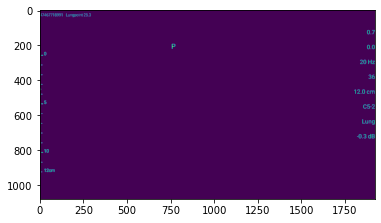

In [10]:
data_paths = sorted(glob("../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding/*.m??"))
img = load_video(data_paths[0])
plt.imshow(img[0]//200)

In [11]:
depth,zoom = get_depth_and_zoom_C52(img[0])
filename = "linear_map_depth" + str(depth) + ".npy"
im_map = np.load(filename)
resampled_img = get_resampled_image_from_mapping(img[0], im_map)

In [12]:
itkimg = itk.GetImageFromArray(resampled_img.astype(np.float32))
itk.imwrite(itkimg,"test.mha")

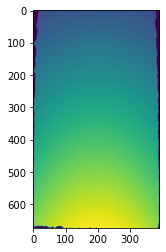

In [13]:
plt.imshow(im_map[:,:,1])